# This notebook examplifies how to use the data we generated to obtain the results we shown in our work. 

## Package and data loading

In [1]:
import numpy as np
import pandas as pd
from pymatgen.core import Structure
from pymatgen.util.plotting import pretty_plot
import pickle
from pymatgen.analysis.xas.spectrum import XAS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import signal

In [2]:
df_computed_xas = pd.read_json("../dataset/nmc_vasp_xas_spectrum.json")
df_computed_xas.head(5)

,energy,intensity,absorbing_atom_idx,structure,abs_spin_density,bond_length,composition,structure_index,oxidation_state
0,"[8330.0, 8330.404040404, 8330.8080808081, 8331...","[0.0103736782, 0.0095451132, 0.0081782685, 0.0...",7,"{'@module': 'pymatgen.core.structure', '@class...",0,1.860580,NMC721,22,4
1,"[8330.0, 8330.404040404, 8330.8080808081, 8331...","[0.0061397962, 0.0052237075, 0.004191436900000...",10,"{'@module': 'pymatgen.core.structure', '@class...",0,1.881317,NMC622,285,4
2,"[8330.0, 8330.404040404, 8330.8080808081, 8331...","[0.0092651838, 0.0079868521, 0.006699605000000...",11,"{'@module': 'pymatgen.core.structure', '@class...",0,1.864153,NMC622,423,4
3,"[8330.0, 8330.404040404, 8330.8080808081, 8331...","[0.0084514812, 0.0072415615, 0.0060316418, 0.0...",8,"{'@module': 'pymatgen.core.structure', '@class...",0,1.860180,NMC622,423,4
4,"[8330.0, 8330.404040404, 8330.8080808081, 8331...","[0.0060607027, 0.005094825000000001, 0.0039997...",6,"{'@module': 'pymatgen.core.structure', '@class...",0,1.860155,NMC622,423,4


## Data processing

In [3]:
# define functions to perform peak fitting 
def func_unfix_width_reg(eng, *params):
    y = np.zeros_like(eng)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp(-((eng - ctr)**2/(2*(wid/2.355)**2)))
    return y
def get_peak_fitting(eng,mu,num_peaks=20):
    idxes = [int(i) for i in np.linspace(0, len(eng)-1, num_peaks+1)]
    idxes_2 = [int((idxes[i] + idxes[i+1]) / 2) for i in range(len(idxes)-1)]
    guess = np.ravel([[eng[i], mu[i], 2] for i in idxes_2])
    lower = np.ravel([[eng[i], min(mu), 0] for i in idxes[:-1]])
    upper = np.ravel([[eng[i], max(mu), 6] for i in idxes[1:]])
    popt, pcov = curve_fit(func_unfix_width_reg, eng, mu, p0=guess, bounds=(lower,upper))
    return popt

Text(0, 0.5, 'Intensity (a.u.)')

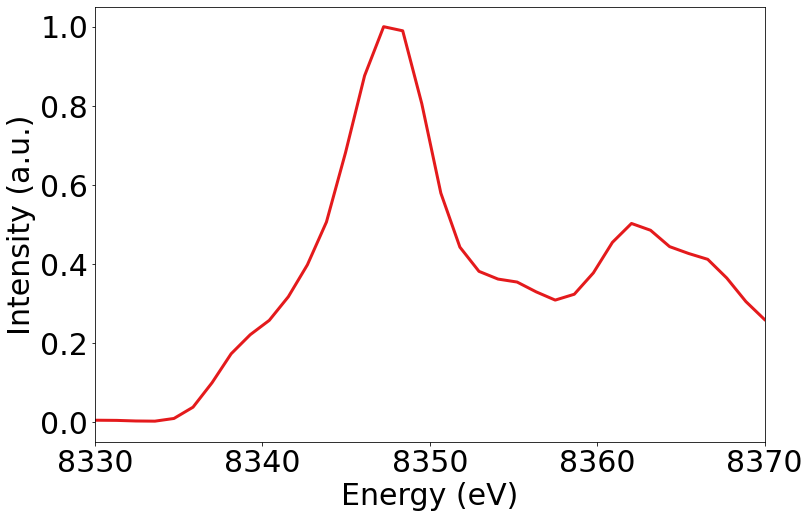

In [4]:
# Read raw output data from vasp outpit, CORE_DIELECTRIC_IMAG.dat 
# This file contains XAS for one absorbing site in NMC721 structure
dat = np.loadtxt("CORE_DIELECTRIC_IMAG.dat", skiprows=2)
xas = XAS([i+120 for i in dat[:,0]], dat[:,1], structure = None, absorbing_element="Ni") 
    # Apply constant 120eV horizontal shift to align exp and vasp computed spectrum
xas.smear(1.27) # Apply Gaussian broadening to computed spectrum
                # A sigma value of 1.27 equals to 3eV FWHM for Gaussian broadening
xas.normalize() # Normalize the spectrum so that the maximum is 1
# Visualize the spectrum after pre-processing
plt = pretty_plot(12,8)
plt.plot(xas.x, xas.y, lw=3)
plt.xlim(8330, 8370)
plt.xticks(np.linspace(8330,8370,5), [int(i) for i in np.linspace(8330,8370,5)])
plt.xlabel("Energy (eV)", fontsize=30)
plt.ylabel("Intensity (a.u.)", fontsize=30)

In [5]:
# Interpolate the spectrum onto uniform energy grid to ensure data consistency 
xaxis = np.linspace(8330,8370,100)
f = interp1d(xas.x, xas.y)
intensity = f(xaxis)

In [6]:
# Generate cumulative distribution function (CDF), peak_feature, continuous wavelet transform (CWT) features 
# from intensity
widths=np.arange(1,11)
cdf = [i/max(np.cumsum(intensity)) for i in np.cumsum(intensity) ]
peak_feature = get_peak_fitting(np.linspace(8330, 8370,100), intensity)
cwt = np.ravel(signal.cwt(intensity, signal.ricker, widths))

Text(0.5, 1.0, 'Cumulative distribution function')

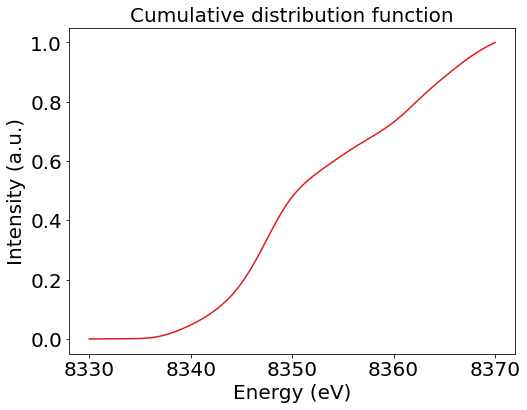

In [7]:
plt = pretty_plot(8,6)
plt.plot(xaxis, cdf)
plt.xticks(np.linspace(8330,8370,5), [int(i) for i in np.linspace(8330,8370,5)])
plt.xlabel("Energy (eV)", fontsize=20)
plt.ylabel("Intensity (a.u.)", fontsize=20)
plt.title("Cumulative distribution function", fontsize=20)

Text(0.5, 1.0, 'Peak feature')

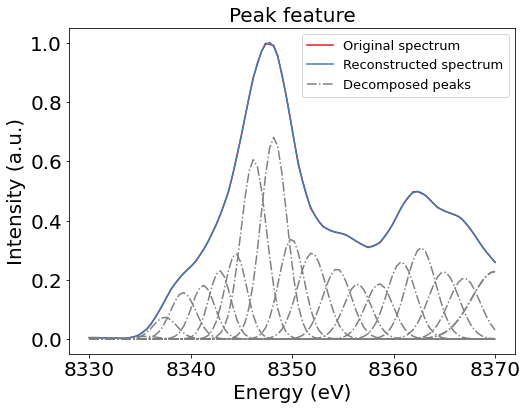

In [8]:
# Visualization for peak fitting 
plt=pretty_plot(8,6)
plt.plot(xaxis, intensity, label="Original spectrum")
plt.plot(xaxis, func_unfix_width_reg(xaxis,*peak_feature), label = "Reconstructed spectrum")
for i in range(0, len(peak_feature), 3):
    ctr = peak_feature[i]
    amp = peak_feature[i+1]
    wid = peak_feature[i+2]
    y = amp * np.exp( -((xaxis - ctr)**2/(2*(wid/2.355)**2)))
    plt.plot(np.linspace(8330,8370,100), y, linestyle='-.', color='grey')
plt.plot(np.linspace(8330,8370,100), y, linestyle='-.', color='grey', label='Decomposed peaks')
plt.xticks(np.linspace(8330,8370,5), [int(i) for i in np.linspace(8330,8370,5)])
plt.legend(loc="best", fontsize=13)
plt.xlabel("Energy (eV)", fontsize=20)
plt.ylabel("Intensity (a.u.)", fontsize=20)
plt.title("Peak feature", fontsize=20)

Text(0.5, 1.0, 'Continuous wavelet transform')

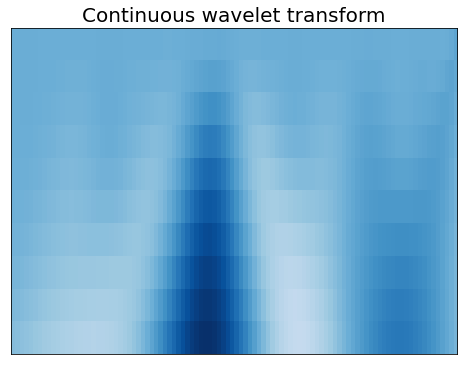

In [9]:
# Visualization for continuous wavelet transform
plt=pretty_plot(8,6)

plt.imshow(signal.cwt(intensity, signal.ricker, widths), cmap='Blues', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.xticks([])
plt.yticks([])
plt.title("Continuous wavelet transform",fontsize=20)

## Model prediction

In [10]:
# Load random forest classifier located in '../model/comp_cdf_rfc_model.pkl' 
# and make an example prediction from previous genered cdf feature
loaded_model = pickle.load(open("../model/comp_cdf_rfc_model.pkl", 'rb'))
result = loaded_model.predict([cdf])
print(result)

[3]


In [11]:
# Load experimental XAS data measured at Advanced Photon Source 
df_exp_nmc622 = pd.read_json("../dataset/nmc_exp_xas_spectrum.json").iloc[0:8,:]
df_exp_nmc622.head(5)

,intensity,cdf,peak_feat,cwt,voltage,composition
0,"[0.0051109158, 0.0063579817, 0.0074947327, 0.0...","[0.00014616610000000002, 0.0003279969000000000...","[1.7623239243, 2.273805895, -0.240354374100000...","[-0.0009841857, 0.002118238, 0.0013976937, 0.0...",N/A,NMC622
1,"[0.0044175222, 0.0056112212000000005, 0.006921...","[0.0001233472, 0.0002800252, 0.000473302600000...","[-1.8250188798, -0.2850945064, -1.3048198121, ...","[-0.0010090145, 0.0014313804, 0.0004993923, 1....",4.3,NMC622
2,"[0.0040510155, 0.005083023000000001, 0.0064758...","[0.0001110142, 0.0002503095, 0.000427774700000...","[0.0335673965, -0.4581485865, 1.1427536546, -0...","[-0.0009382213, 0.0011312744, 0.0001658032, -0...",4.8,NMC622
3,"[0.0036601631, 0.0045720186, 0.005441736, 0.00...","[0.0001145933, 0.00025773530000000003, 0.00042...","[0.26534834620000003, -0.1018136464, -1.239266...","[-0.0007304372, 0.0014576762, 0.0009149821, 0....",3.0,NMC622
4,"[0.0038011293, 0.0047582182, 0.006007694300000...","[0.0001090561, 0.0002455715, 0.0004179349, 0.0...","[-0.14317505190000002, -0.7626770983000001, 1....","[-0.0008607818000000001, 0.0011005548, 0.00019...",4.3,NMC622


In [12]:
# Load trained random forest model for inference on experimental data and 
# predict the oxidation states from CDF features
exp_model = pickle.load(open("../model/exp_cdf_rfr_model.pkl", 'rb'))
result = exp_model.predict(df_exp_nmc622.loc[:,'cdf'].to_list())
print(result)

[3.4197402  3.98452288 3.98452288 3.34768848 3.98663399 3.98491177
 3.98491177 3.38892804]


/Users/yiming/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Predicted oxidation states for NMC622 system')

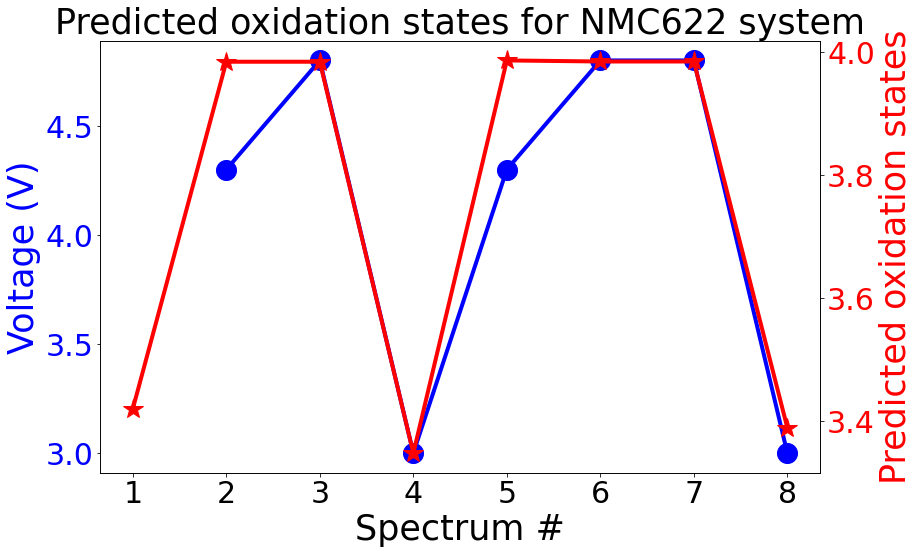

In [13]:
# Visualize the results along with measured voltage
fig = plt.figure(figsize=(10,6))
a1 = fig.add_axes([0,0,1,1])
a1.plot(np.arange(1,8), df_exp_nmc622['voltage'][1:], 'o-', 
        lw=4, markersize=20, color='blue', label='Voltage')
a2 = a1.twinx() 
a2.plot(np.arange(8), result, '*-', lw=4, markersize=20, color='red', label='CDF')

a1.set_ylabel('Voltage (V)', fontsize=35)
a1.set_xlabel("Spectrum #", fontsize=35)
a1.tick_params(axis='y', labelsize=30, labelcolor='blue')
a1.yaxis.label.set_color('blue')
a1.tick_params(axis='x', labelsize=30)
a1.set_xticklabels(np.arange(0,9))

a2.yaxis.label.set_color('red')
a2.set_ylabel('Predicted oxidation states', fontsize=35)
a2.tick_params(axis='y', labelsize=30, labelcolor='red')

plt.title("Predicted oxidation states for NMC622 system", fontsize=35)